# Lab 3 — recommender systems

In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np

from operator import itemgetter

%matplotlib inline
plt.style.use("ggplot")

---
The print_state function gives an indication of advancement for a long loop

In [2]:
def print_state(i , modulo, length) :
    
    if (i % modulo == 0):
        print("\r", 100*i/length, " %", end="")

What does the data look like?

In [3]:
!hdfs dfs -cat /ix/ml-20m/ratings.txt | tail -n 2

{"movieId": 70286, "userId": 138493, "timestamp": 1258126944, "rating": 5.0}
{"movieId": 71619, "userId": 138493, "timestamp": 1255811136, "rating": 2.5}


In [4]:
# DEFINE THE FOLLOWING CONSTANTS

MOVIE = 0
USER = 1
TIMESTAMP = 2
RATING = 3

In [5]:
data = sc.textFile("/ix/ml-20m/ratings.txt").map(json.loads)

### 3.4 Basic statistics

##### We first create the list of all users and the list of all movies

In [6]:
user_list = data.map(itemgetter("userId")).collect()
movie_list = data.map(itemgetter("movieId")).collect()

###### We use the function np.unique with the parameter [return_counts = True] to obtain  the number of ratings for each unique user/film

In [7]:
unique_users, nb_rating_foreach_user = np.unique(user_list, return_counts = True)

unique_movies, nb_rating_foreach_movie = np.unique(movie_list, return_counts = True)

In [8]:
print("there are", len(unique_users), " differents users")
print("there are", len(unique_movies)," differents movies")

there are 138493  differents users
there are 26744  differents movies


---

We define a sorted_plot function to answer the question :

In [9]:
def sorted_plot(data, x_label, bins = 200):

    # ========== Plot Parameters ==========

    plt.figure(figsize=(9,9))
    
    forX = x_label + " (ids do not match anymore because of the sort)"
    forY = "number of ratings"
    forTitle = "Graph representing the number of ratings per " + x_label + " (sorted)"
    
    plt.xlabel(forX, fontsize = 15)
    plt.ylabel(forY, fontsize = 15)
    plt.title(forTitle, fontsize = 18)
    
    plt.plot(sorted(data))

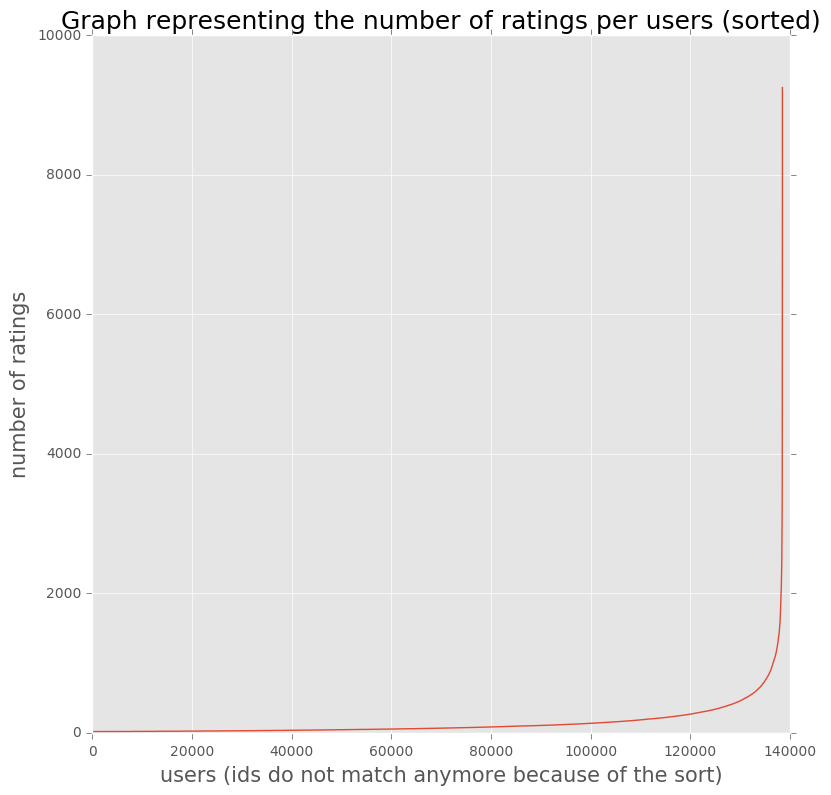

In [10]:
sorted_plot(nb_rating_foreach_user, "users")

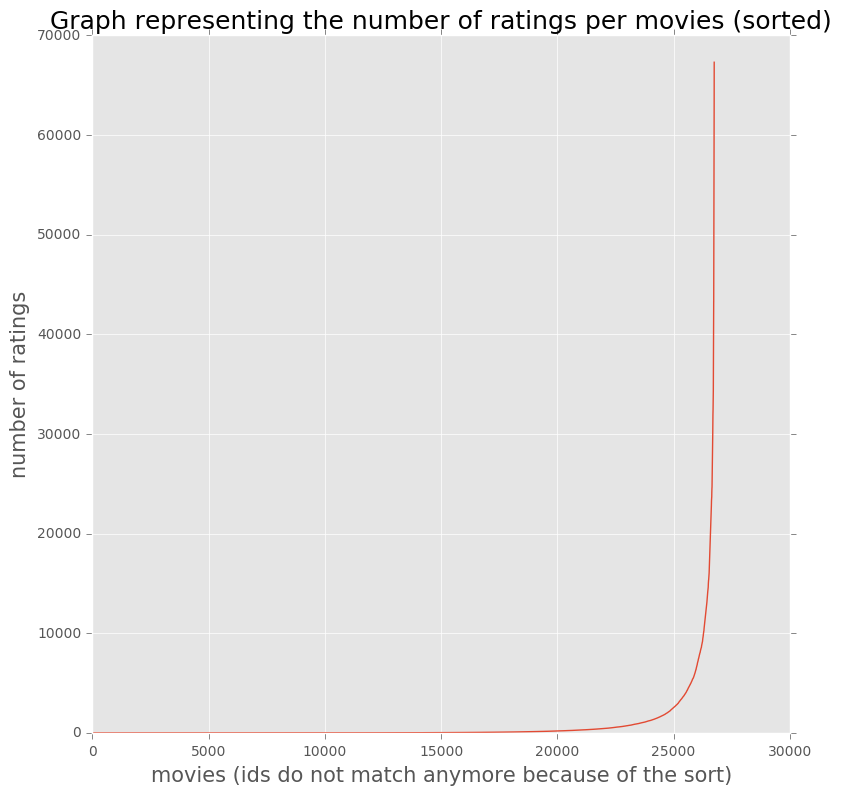

In [11]:
sorted_plot(nb_rating_foreach_movie, "movies")

###### Rating distribution : 

We see that the majority of users rated only a few films and a little group of users rated an enormous amount of films.

The same applies for the movies :
We see that the majority of movies has only been rated a few times, while a little group of films (the most known ones) has bee rated thousands of times.

### My ratings

In [10]:
%run rate-movies.py

Please rate the following movies.
1 (worst) -- 5 (best), or 0 if not seen

Toy Story (1995)
Adventure, Animation, Children, Comedy, Fantasy
your rating: 4

Independence Day (1996)
Action, Adventure, Sci-Fi, Thriller
your rating: 0

Dances with Wolves (1990)
Adventure, Drama, Western
your rating: 0

Star Wars: Episode VI - Return of the Jedi (1983)
Action, Adventure, Sci-Fi
your rating: 3

Mission: Impossible (1996)
Action, Adventure, Mystery, Thriller
your rating: 3

Ace Ventura: Pet Detective (1994)
Comedy
your rating: 0

Die Hard: With a Vengeance (1995)
Action, Crime, Thriller
your rating: 0

Batman Forever (1995)
Action, Adventure, Comedy, Crime
your rating: 1

Pretty Woman (1990)
Comedy, Romance
your rating: 4

Men in Black (1997)
Action, Comedy, Sci-Fi
your rating: 4

Dumb & Dumber (1994)
Adventure, Comedy
your rating: 4

Successfully saved 7 ratings in `my-ratings.txt`
Your user ID: 138494


### 3.5 Partitionning the dataset

###### First we create a list of dict with our txt file

In [12]:
file = open("my-ratings.txt")
to_be_added = []


for line in file :
    to_be_added.append(json.loads(line))
file.close()

###### Then we add it to our RDD

In [13]:
additional = sc.parallelize(to_be_added)

combined = data.union(additional)

###### Now we split in in training and test sets

In [14]:
#Elements of our RDD are dictionaries
def training_set(dico): return (dico['timestamp'] % 10) < 8

def testing_set(dico): return not (training_set(dico))


training = combined.filter(training_set)
testing = combined.filter(testing_set)

### IMPORTANT NOTE :

For the alphas and betas computation, it was too late when I realized that the RDD had functions like 'groupByKey' that could really simplify the code.

We know that the following code needs a lot of storage memory, but the results are quite good and we find an error below the required one.

###### We create usefull lists (Those are built from the training RDD,   NOT the entire data RDD) :


In [15]:
elements = training.map(itemgetter("movieId", "userId", "timestamp", "rating")).collect()

In [16]:
rating_list = np.array(training.map(itemgetter("rating")).collect())

In [17]:
user_list = np.array(training.map(itemgetter("userId")).collect())

In [18]:
movie_list = np.array(training.map(itemgetter("movieId")).collect())

In [19]:
# unique_users contains all users in a sorted order and only once

# user_first_appearance_in_elem contains the index of the first occurence of any user in the starting array 'elements'
# => retrieve the global shape of 'elements' from unique_users

# nb_rating_foreach_user is explicit

unique_users, user_first_appearance_in_elem, nb_rating_foreach_user = np.unique(user_list,
                                                                                return_index = True,
                                                                                return_counts = True)

In [20]:
# unique_movies contains all movies in a sorted order and only once

# nb_rating_foreach_user is explicit

unique_movies, nb_rating_foreach_movie = np.unique(movie_list, return_counts = True)

###### We also create usefull dictionaries :

Please note that :
- UUI = Unique User Idex = index of this user in 'unique_users' array
- UMI = Unique Movie Idex = index of this movie in 'unique_movies' array

In [21]:
UUI_2_userID = dict(enumerate(unique_users))

userID_2_UUI = {v: k for k, v in UUI_2_userID.items()}

In [22]:
UMI_2_movieID = dict(enumerate(unique_movies))

movieID_2_UMI = {v: k for k, v in UMI_2_movieID.items()}

In [23]:
tuple_2_rating = {(movie, user):rating for movie,user,t,rating in elements}

###### And some length constants

In [24]:
len_elem = len(elements)
len_u = len(unique_users)
len_m = len(unique_movies)

## 3.2.1 Baseline recommender system

### 3.6 Baseline model

In [25]:
mean = np.mean(rating_list)

---

To build alphas[] we need to iterate over all unique_users and over all the movies they have rated. The latter task is simple because in 'elements' the data is ordered by user (which justifies the j-for-loop)

The data looks like : 
- (randomMovie, userA, time, rating) 
- (randomMovie, userA, time, rating)
- (randomMovie, userA, time, rating)
- (randomMovie, userA, time, rating)
- (randomMovie, userB, time, rating)
- (randomMovie, userB, time, rating)
- (randomMovie, userB, time, rating)
- (randomMovie, userC, time, rating)
- (randomMovie, userC, time, rating)
- (randomMovie, userC, time, rating)
....

In [26]:
alphas = []

# For all users
for i in range (len_u) :
    
    # The number of ratings of our user
    Nu = nb_rating_foreach_user[i]
    
    # The id of our user
    u_id = unique_users[i] 
    
    # Index of the first apperance of this user
    ufa = user_first_appearance_in_elem[i]
    
    sum_rum = 0;
    
    # Iterate over every ratings of our user
    for j in range (Nu):      
        sum_rum += elements[ufa + j][RATING] - mean
            
    
    temp_alpha = sum_rum/float(Nu)
    alphas.append(temp_alpha)
    
    print_state(i, 30, len_u)
    
print("\r 100 %")

 100 %


Now we append a last value which is equal to the mean of alphas[].
This value will be accessed for movies in 'testinng' that do not appear in 'training'

In [27]:
ACCESS_DEFAULT_ALPHA = len_u

alphas.append(np.mean(alphas))

---
Computing the betas[] is a bit more complicated because for one movie, all the ratings are not grouped together as the users were. Iterating over all the 'elements' array     *#movies*   times is way to long !

###### So we must create a list linking any unique movie with the list of all users_id that have rated it.
=> We iterate over 'elements' only once !

In [28]:
'''WARNING : This must be accessed with Unique Movie Index'''
all_users_related_to_movie = [None] * len_m

for UMI in range (len_m) :
    all_users_related_to_movie[UMI] = []
    
for i in range (len_elem) :
    
    e = elements[i]
    
    # UMI = Unique Movie Index
    UMI = movieID_2_UMI[ e[MOVIE] ]
    
    all_users_related_to_movie[UMI].append( e[USER] )

    print_state(i, 30, len_elem)
    
print("\r 100 %")

 100 %


###### Now we can compute the item bias beta for each movie :

For each movie :
- access all the users that rated it (see cell above)
- access the rating of this user about this film with the dictionary 'tuple_2_rating'
- access the user position in 'alphas[]' thanks to userID_2_UUI
- access to the alpha value of this user

- Compute the beta value and append it to betas[]

In [29]:
betas = []

# For all movies (Unique Movie Index)
for UMI in range (len_m) :
    
    # The number of ratings of our movie
    Nm = nb_rating_foreach_movie[UMI]
    
    # The id of our movie in the 'unique_movie' array
    m_id = unique_movies[UMI]
    
    # Beware ! Those are userID !
    linked_users = all_users_related_to_movie[UMI]
    
    
    # To be computed
    sum_rum = 0
        
    for u in linked_users:
        
        # Recall : alphas are ordered in the same way as unique_user (alphas[k] is for unique_user[k])
        # So in order to find alpha_u, we need to :
                
        # - use our previously computed dictionary to take the UUI of this user
        
        # - access alphas with this UUI
        
        UUI = userID_2_UUI[u]
        
        alpha_u = alphas[UUI]
        
        rating = tuple_2_rating.get((m_id, u), mean) # The second argument is the default value in case the rating does not exist

        sum_rum += rating - mean - alpha_u
    
    
    temp_beta = sum_rum/float(Nm)
    betas.append(temp_beta)
    
    print_state(UMI , 2, len_m)

print("\r 100 %")

 100 %


We now append a last value to handle the case when a movie in 'testing' doest not appear in 'training'

In [30]:
ACCESS_DEFAULT_BETA = len_m

betas.append(np.mean(betas))

---

We are working with 2 sets of parameters : alphas and betas

So the global number of parameters is alphas * number_of_users  +  betas * number_of_films

In [31]:
print("Nb parameters = ", len(alphas) + len(betas))

Nb parameters =  164321


----

###### Now we create all the following data structures.
###### They are needed in the error computation

In [32]:
test_elements = testing.map(itemgetter("movieId", "userId", "timestamp", "rating")).collect()

In [33]:
len_test = len(test_elements)

In [34]:
# The real values of the ratings, in order to do a comparison with our estimations
tuple_2_true_value = {(user, movie):rating for movie,user,t,rating in test_elements}

In [35]:
# Needed to iterate over all user_ID in error()
users_test = np.array(testing.map(itemgetter("userId")).collect())

# Needed to get Nu and to get all the movies related to a user in error()
unique_test_users, user_first_appearance_in_test, nb_test_rating_foreach_user = np.unique(users_test,
                                                                                         return_index = True,
                                                                                         return_counts = True)

In [36]:
UUI_2_userID_test = dict(enumerate(unique_test_users))
userID_2_UUI_test = {v: k for k, v in UUI_2_userID_test.items()}

---
###### We can now build a RDD (user, movie, guess) with our estimations

Please note that :
- Movies (resp users) that have no UMI (resp UUI) have no beta (resp alpha) value
 => We will use the default values of alpha and beta that we added 'by hand'

In [37]:
# A list of triples
to_parallelize = []

len_test = len(test_elements)

for i in range(len_test):

    
    # -------- Shortcuts --------
    user_id = test_elements[i][USER]
    movie_id = test_elements[i][MOVIE]

    UUI = userID_2_UUI.get(user_id, ACCESS_DEFAULT_ALPHA)
    UMI = movieID_2_UMI.get(movie_id, ACCESS_DEFAULT_BETA)
    
    # -------- Computing --------
    
    guess = mean + alphas[UUI] + betas[UMI]
    
    triple = (user_id, movie_id, guess)

    to_parallelize.append(triple)
    
    # ----- Printing the state -----
    print_state(i, 30, len_test)

print("\r 100 %")



 100 %


In [38]:
guess_rdd = sc.parallelize(to_parallelize)

### 3.7 Evaluation

In [39]:
def error (rdd) :
    
    """This function takes a rdd (userID, movieID, guess) and returns the mean square error
    with respect to the true value of the ratings"""
    
    # --------- Convert Rdd into dict(tuple => guess) ---------
    list_rdd = rdd.collect()
    tuple_2_guess = {(u, m) : g for u, m, g in list_rdd}
    
    # --------- Init ---------
    U = len(unique_test_users)
    error = 0
    
    
    # --------- Loop over every single user ---------

    for UUI in range (U):
        
        # Take his ID and his Nu
        user_id = unique_test_users[UUI]
        Nu = nb_test_rating_foreach_user[ UUI ]
        
        # Starting point of the movies related to him
        ufa = user_first_appearance_in_test[ UUI ]
        
        m_sum = 0
        
        # --------- Loop over every movie related to him ---------
        for j in range(Nu):

            movie_id = test_elements[ufa + j][MOVIE]
            
            # --------- Apply the formula ---------
            t = (user_id, movie_id)
            diff = tuple_2_guess.get(t, mean) - tuple_2_true_value[t]
            
            m_sum += diff*diff
        
        error += np.sqrt(m_sum/float(Nu))

    return error/float(U)   

In [40]:
print("The observed error is : ", error(guess_rdd))

The observed error is :  0.866910321527


## 3.2.2 Matrix-factorization model

### 3.8 Regularization

In [41]:
from pyspark.mllib.recommendation import ALS 

###### We modify our training RDD to have it in the form (userID, movieID, rating)

The trade-off :

- High-rank = good precision but long running time.
- Low-rank = less precise but much more efficient

In [42]:
def test_lambda (l) :
    
    model = ALS.train(training.map(itemgetter("userId", "movieId", "rating")), 10, iterations=10, lambda_ = l)
    
    pred = model.predictAll(testing.map(itemgetter("userId", "movieId")))
    
    e = error(pred)
    print("The error with lambda = ", l, " is : ", e)
    
    return e

In [46]:
e000_1 = test_lambda(0.0001)
e1 = test_lambda(1.0)
e10 = test_lambda(10.0)

The error with lambda =  0.0001  is :  0.885889216899
The error with lambda =  1.0  is :  1.33024301474
The error with lambda =  10.0  is :  3.74548647887


Thanks to the previous cell, we can imagine that the least error is reached for a value between 0.0001 and 1.

#### That's why we perform a binary search

In [4]:
best_err = e1
best_lambda = 0

bound1 = 0.0001
bound2 = 1.0


for i in range (10):

    new_try = 0.5*(bound1 + bound2)

    err = test_lambda(new_try)

    if (err < best_err):
        best_lambda = new_try
        best_err = err
        bound2 = new_try

    else :
        bound1 = new_try

print("\n\nThe best lambda is ", best_lambda, "which gives an error of ", best_err)



We can see that the error decreases from 0.86 to 0.796 which is quite good for a large dataset like this one.

### 3.9 Recommendation


###### Now I can train a model with the desired lambda

In [43]:
best_lambda = 0.06259
model = ALS.train(training.map(itemgetter("userId", "movieId", "rating")), 10, iterations=10, lambda_ = best_lambda)

In [44]:
movie_data = sc.textFile("/ix/ml-20m/movies.txt").map(json.loads)

In [45]:
movie_list = movie_data.map(itemgetter("movieId", "title")).collect()


---
We create a dict to map movieId to title

In [92]:
id_2_title = {movieId:title for movieId, title in movie_list}

---

And we recommend movies for user 123 and I

In [47]:
def recommend(userId, n=10) :
    
    r = model.recommendProducts(userId, n)
    
    print("Recommendations for user", userId)
    
    for user, product, rating in r :
        print(id_2_title[product])
    
    print ("\n\n") 

In [48]:
recommend(123)
recommend(138494)

Recommendations for user 123
Jim Jefferies: Alcoholocaust (2010)
Carmina and Amen (Carmina y amén) (2014)
My Life as McDull (Mak dau goo si) (2001)
Hamoun (1990)
Nursery University (2008)
Habit (1995)
Karthik Calling Karthik (2010)
Fitzgerald Family Christmas, The (2012)
Shoppen (2006) 
What Will You Do When You Catch Me? (Co mi zrobisz jak mnie zlapiesz?) (1978)



Recommendations for user 138494
Mimino (1977)
Sarah Silverman:  We Are Miracles (2013)
Charlie Chan in Shanghai (1935)
The War at Home (1979)
Connections (1978)
Watch Out for the Automobile (Beregis avtomobilya) (1966)
Rising Place, The (2002)
Merry Widow, The (1925)
Dirty Bomb (2011)
Army of Crime (L'armée du crime) (2009)





I do not know any of these films, but this is a good occasion to discover new things !

### Visualization

In [57]:
import pickle

We create a new model with rank 2

In [51]:
rank2_model = ALS.train(training.map(itemgetter("userId", "movieId", "rating")), 2, iterations=10, lambda_ = best_lambda)

We extract the product features and create a dictionnary (movieId => values)

In [65]:
features = rank2_model.productFeatures()

In [66]:
dico = features.collectAsMap()

We print the bokeh graph with a bright color representing a good grade

In [89]:
with open("selected-movies.pickle", "rb") as f:
    movies = pickle.load(f, encoding="utf-8")

unique_identifier = 0
data = list()

for movie in movies:
            
    coordinates = dico.get(movie[0], [0,0])
    
    # Create data used by Bokeh
    data.append((coordinates[0], coordinates[1], movie[1], movie[2], unique_identifier))
    
    unique_identifier += 1

In [90]:
from bokeh.io import show, output_notebook
from bokeh.plotting import figure, ColumnDataSource
from bokeh.models import HoverTool, ResetTool, PanTool, WheelZoomTool, SaveTool
output_notebook()

Loading BokehJS ...

In [5]:
# Categorial colors : THESE PALETTES CONTAIN 256 COLORS !
from bokeh.palettes import Greys256


source = ColumnDataSource(
    data={
        "x": [x[0] for x in data],
        "y": [x[1] for x in data],
        "name": [x[2] for x in data],
        
        # Accessing the palette with an integer : 255 * grade_between_0_and_1
        "color": [(Greys256[int(x[3]*255)]) for x in data],
        
    })

hover = HoverTool(
    tooltips=[
        ("Name", "@name"),
    ])
tools = [hover, ResetTool(), PanTool(), WheelZoomTool(), SaveTool()]

p = figure(plot_width=960, plot_height=360, tools=tools, title="Films projected on the two main eigenvectors. The brighter the color, the better the mark")
circle = p.circle("x", "y", source=source, size=20, color="color", alpha=0.5)
glyph = circle.glyph
glyph.line_color = "black"
show(p, notebook_handle=True)

ImportError: cannot import name 'Greys256'